## Mount drive and set current directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/1006')
print(os.getcwd())

/content
/content/drive/My Drive/1006


## Random Pick

In [ ]:
from random import choices

def random_indices(max_obs, num_obs):
  return choices(range(max_obs), k=num_obs)

## K-means Clustering

In [ ]:
!pip install fast-pytorch-kmeans

In [ ]:
from fast_pytorch_kmeans import KMeans
import torch
from random import choices

def kmeans_indices(obs, num_obs):
  kmeans = KMeans(n_clusters=num_obs, mode='euclidean', verbose=1)
  labels = kmeans.fit_predict(obs)
  label_idx_dict = {}
  for index, label in enumerate(labels):
    label = label.item()
    if label in label_idx_dict:
      label_idx_dict[label].append(index)
    else:
      label_idx_dict[label] = [index]
  indices = [choices(label_idx_dict[key], k=1)[0] for key in label_idx_dict]
  if len(indices) < num_obs:
    more_indices = [choices(label_idx_dict[key], k=1)[0] for key in label_idx_dict]
    for idx in more_indices:
      if idx not in indices:
        indices.append(idx)
      if len(indices) == num_obs:
        break
  return indices

In [ ]:
#from sklearn.cluster import MiniBatchKMeans
#kmeans = MiniBatchKMeans(n_clusters=5000, random_state=0, batch_size=100, max_iter=20, init_size=10000).fit(data)
#kmeans.labels_

## Farthest Point Sampler

In [ ]:
import numpy as np

def farthestPointSampler(dist_matrix, num_obs):
  indices = np.zeros(num_obs, dtype=np.int64)
  # select two farthest points
  indices[0], indices[1] = np.unravel_index(dist_matrix.argmax(), dist_matrix.shape)
  for i in range(2, num_obs):
    # maximize minimum distance to all points in indices
    sorted_indices = np.argsort(np.min(dist_matrix[indices[:i],:], axis=0))[::-1]
    #sorted_indices = np.setdiff1d(sorted_indices, indices[:i])
    sorted_indices = sorted_indices[~np.in1d(sorted_indices, indices[:i])]
    indices[i] = sorted_indices[0]
  return indices

(80, 80)
[43 50 54 62 58 16 79  7 45  9 67 74  3]


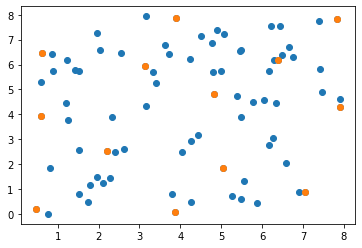

In [ ]:
# test farthestPointSampler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

x = np.random.uniform(0, 8, (80,2))

d = pairwise_distances(x, x)
print(d.shape)

disted = farthestPointSampler(d, 13)
print(disted)
plt.scatter(x[:,0], x[:,1])
plt.scatter(x[disted,0], x[disted,1])

## Greedy farthest point based on KL Divergence

In [ ]:
# Basis: normal distribution in all embeddings

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

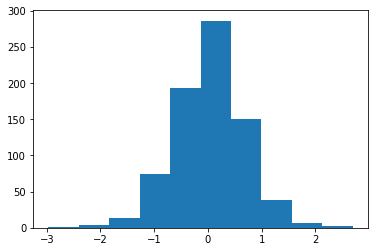

In [ ]:
"""data = pd.read_csv('news_roberta_train.csv', index_col=0)
data.head()
data = data.to_numpy()
data.shape
plt.hist(data[6789,:])
plt.show()"""

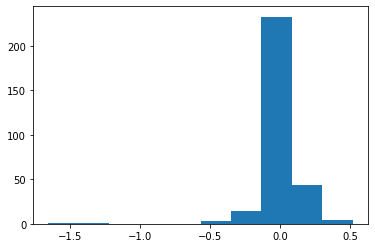

In [ ]:
"""data = pd.read_csv('eo_glove6B_train.csv', index_col=0)
data.head()
data = data.to_numpy()
data.shape
plt.hist(data[174,:])
plt.show()"""

In [ ]:
from scipy.stats import norm
from itertools import combinations_with_replacement
from itertools import chain
import numpy as np

def fit_norm(obs):
  mu_list = []
  sd_list = []
  n_obs = obs.shape[0]
  for i in range(n_obs):
    mu, sd = norm.fit(obs[i,:])
    mu_list.append(mu)
    sd_list.append(sd)
  return mu_list, sd_list

def gaussian_kld(mu1, sd1, mu2, sd2):
  return np.log(sd2/sd1) + ((sd1**2 + (mu1-mu2)**2) / (2*(sd2**2))) - 0.5

def get_kld_matrix(mu_list, sd_list, dataset_name="", embed_type=""):
  dshape = len(mu_list)
  kld_matrix = np.zeros((dshape, dshape))
  looper = combinations_with_replacement(range(dshape), 2)
  for i, j in looper:
    kld_ij = gaussian_kld(mu_list[i], sd_list[i], mu_list[j], sd_list[j]) + gaussian_kld(mu_list[j], sd_list[j], mu_list[i], sd_list[i])
    kld_matrix[i][j] = kld_ij
    kld_matrix[j][i] = kld_ij
  print('Saving kld matrix...')
  np.save(dataset_name+'_kld_'+embed_type, kld_matrix)
  #return kld_matrix
  return dataset_name+'_kld_'+embed_type+'.npy'

In [ ]:
#kld_matrix = np.load('outfile_name.npy')

## Greedy Farthest Point Sampler using Kolmogorov-Smirnov measure

In [ ]:
def ks_2samp_faster(data1, data2):
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / data1.shape[0]
    cdf2 = np.searchsorted(data2, data_all, side='right') / data2.shape[0]
    cddiffs = cdf1 - cdf2
    minS = np.clip(-np.min(cddiffs), 0, 1)  # Ensure sign of minS is not negative.
    maxS = np.max(cddiffs)
    d = max(minS, maxS)
    return d

In [ ]:
def get_ks_matrix(obs, dataset_name="", embed_type=""):
  num_obs = len(obs)
  ks_matrix = np.zeros((num_obs, num_obs))
  obs = np.sort(obs, axis=1)
  for i in range(num_obs):
    for j in range(i, num_obs):
      val = ks_2samp_faster(obs[i], obs[j])
      ks_matrix[i][j] = val
      ks_matrix[j][i] = val
  print('Saving ks matrix...')
  np.save(dataset_name+'_ks_'+embed_type, ks_matrix)
  return dataset_name+'_ks_'+embed_type+'.npy'

## Greedy Farthest Point Sampler using Cosine Distance Matrix


In [ ]:
from scipy.spatial.distance import cosine
def get_cos_matrix(obs, dataset_name="", embed_type=""):
  num_obs = len(obs)
  cos_matrix = np.zeros((num_obs, num_obs))
  for i in range(num_obs):
    for j in range(i, num_obs):
      val = cosine(obs[i], obs[j])
      cos_matrix[i][j] = val
      cos_matrix[j][i] = val
  print('Saving cosine matrix...')
  np.save(dataset_name+'_cos_'+embed_type, cos_matrix)
  return dataset_name+'_cos_'+embed_type+'.npy'

In [ ]:
'''import random
def greedy_entropy(kld_dict, n):
  m = kld_dict.shape[0]
  init_set = list(range(0, m))
  repr_set = random.sample(range(0, m-1), n)
  init_set -= repr_set
  break_flag = True
  while break_flag:
    repr_set_list = list(repr_set)
    for r in repr_set_list:
      init_set.update({r})
      repr_set -= {r}
      max_dist = -1
      max_point = -1
      for a, b in product(init_set, repr_set):
        if a<=b:
          kld = kld_dict[(a,b)]
        else:
          kld = kld_dict[(b,a)]
        if kld > max_dist:
            max_dist = kld
            max_point = a
      repr_set.update({max_point})
      init_set -= {max_point}
    if repr_set == set(repr_set_list):
      break_flag = False
  return repr_set'''